In [1]:
import sys
import os

# Fix relative import issue, append root path to sys.path
parent = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent)

In [ ]:
from utils.dataset import MoleculeDataset
from utils.trainer import ModelTrainer
from models import SimpleMoleculeGCN, AdvancedMoleculeGNN

from pprint import pprint

import torch
from sklearn.model_selection import train_test_split
from torch_geometric.loader import DataLoader

In [9]:
dataset = MoleculeDataset('../data/raw/ESOL.csv', target_col='measured log solubility in mols per litre')
dataset = [data for data in dataset if data is not None]

train_dataset, temp = train_test_split(dataset, test_size=0.3, random_state=42)
val_dataset, test_dataset = train_test_split(temp, test_size=0.5, random_state=42)

In [19]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
num_node_features = MoleculeDataset._N_NODE_FEATURES  # Based on get_atom_features (grabbed only 6 feature, have to increase)
num_edge_feature = MoleculeDataset._N_EDGE_FEATURES  

modelGCN = SimpleMoleculeGCN(
    num_node_features=num_node_features,
    hidden_dim=128,
    num_classes=1
)

modelGNN = AdvancedMoleculeGNN(
    num_node_features=num_node_features,
    num_edge_features=num_edge_feature, 
    hidden_dim=128,
    num_classes=1
)

model = modelGNN

sum([p.numel() for p in model.parameters()])

43009

In [38]:
trainer = ModelTrainer(model)
trainer.fit(
    train_loader, 
    val_loader, 
    epochs=5, 
    lr=0.001,
    task='classification',
    patience=15
)

criterion = torch.nn.BCEWithLogitsLoss()
test_loss, test_metric, metric_name = trainer.evaluate(test_loader, criterion, 'classification')
print(f'\nTest Results: Loss: {test_loss:.4f}, {metric_name}: {test_metric:.4f}')

Training: 100%|██████████| 25/25 [00:03<00:00,  8.24it/s]


Epoch 001: Train Loss: -1758.9573, Val Loss: -2171.8742, Val ROC-AUC: 0.5823


Training: 100%|██████████| 25/25 [00:03<00:00,  7.74it/s]


Epoch 002: Train Loss: -2105.7569, Val Loss: -2315.6208, Val ROC-AUC: 0.5442


Training: 100%|██████████| 25/25 [00:02<00:00, 11.15it/s]


Epoch 003: Train Loss: -2459.8588, Val Loss: -3139.8441, Val ROC-AUC: 0.5562


Training: 100%|██████████| 25/25 [00:02<00:00, 10.55it/s]


Epoch 004: Train Loss: -2996.0385, Val Loss: -3130.8667, Val ROC-AUC: 0.5723


Training: 100%|██████████| 25/25 [00:02<00:00,  9.80it/s]


Epoch 005: Train Loss: -3551.3556, Val Loss: -4103.6120, Val ROC-AUC: 0.5663
Training completed. Best validation loss: -4103.6120

Test Results: Loss: -3379.4743, ROC-AUC: 0.7595


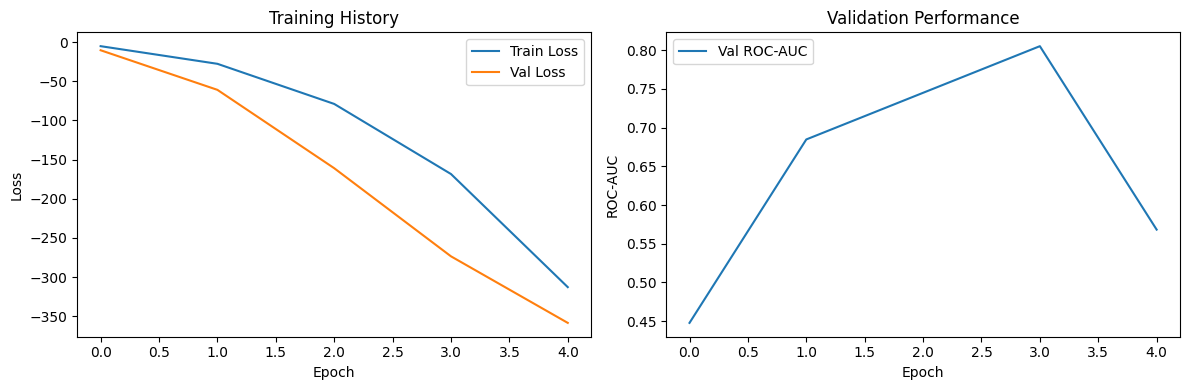

In [35]:
import matplotlib.pyplot as plt
    
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(trainer.history['train_loss'], label='Train Loss')
plt.plot(trainer.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training History')

plt.subplot(1, 2, 2)
plt.plot(trainer.history['val_metric'], label='Val ROC-AUC')
plt.xlabel('Epoch')
plt.ylabel('ROC-AUC')
plt.legend()
plt.title('Validation Performance')

plt.tight_layout()
plt.show()